## What's in a name? 
### A tutorial on my machine-learning workflow for predicting whether or not this post will be popular!

The purpose of the notebook is to describe my efforts to predict whether or not a post to the /r/datascience subreddit will be a success.  I define success as receiving more than the average number of votes.  What's unique about my methodology is that the prediction is based solely on the title of the redditor's post, hence the blog title: What's in name?.

### Caveats
Yes, I do know that day and time are powerful predictors of votes(likes,retweets) but I didn't want to confine/limit my prediction to these temporal parameters.  I am also aware that the predictive power of this model is barely good thus suggested improvements woul be greatly appreciated.  I must remind you that this is my first dive into NLP and I might have made careless mistakes and overlooked obvious problems or solutions. Please be kind in your criticism. 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from feature_extraction import Blob, Words, Exclude, WordCount, POS, Readable
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif, SelectFromModel
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from calzone_keras import describe, lemmatize


You can install all packages above: 'pip install -r [requirements.txt]({filename}/data/requirements.txt)'

# Steps 1 - 4 (tldr)
1.  Reads in csv-formatted subreddit data.  
    1a. You can use the grab_posts function to collect posts inline
2.  Optional: Data manipulation  
    2a. Obtain normal distribution of votes by applying log transformation.  
    2b. Remove outliers using z-scores greater than -2.5 and less than 2.5
3.  Create labeled data (It is the boolean set to whether or not a title will be popular )
4.  Split data into training and test 

### Let's begin!
The first step of predicting the success of a post is grabbing [/r/datascience](https://www.reddit.com/r/datascience) submissions.  I provide the a year's worth of [data](processed_datascience.csv.bz2) below however you can grab your own data by using the script [calzone.py](calzone.py) 

The second step is to clean up the data.  This can include removing characters or changing the case of words in the titles but most importantly it included dealing specifically with the number of votes that each title received.  We noticed that there were votes that were wildly different than the rest.  To handle these anomalies we removed the outliers based on z-scores.  We then log transformed the votes in order to obtain a normal distribution.  In the histogram below you can see that without normalization the number of votes is left-skewed.

Thirdly, we specify the target.  The target is the class that is being predicted.  In our case, we are trying to predict whether or not a post receives greater than the average number of votes (SUCCESS!).  For this dataset, the average is 7.5 votes.

Fourthly, we split the data into training and test sets.

#### *** Side note ***
* Use: "python calzone.py -h" for explanation of script commands. 
* Edit: config.praw.ini settings for calzone.py to work.

In [3]:
#Read in posts

data = pd.read_csv('processed_datascience.csv.bz2')

# You can use the grab_posts module if you want to grab posts from specific subreddits and time-frames
# To retrieve your own posts requires a reddit developer account
#from calzone import grab_posts
#data = grab_posts(sub='todayilearned', start='01/24/2018', end='02/05/2018', number=30000, verbose=True)

# Data clean - 
# 1. remove '/' character
# 2. lowercase all letters
# 3. lemmatize all words - change words to their root words, ie 'wanted -> want'
data['title'] = lemmatize(data)


## Optional: Throw out outliers by including rows with Z-Scores less than 2.5 and greater than -2.5
data['z_scores'] = np.abs((data.ups-data.ups.mean())/data.ups.std())
data = data[data['z_scores']<= 2.5]

## Optional: Log transformation of up-votes
data['log_ups'] = np.log1p(data['ups'])

# Create Label column defining whether or not the article's votes exceed the average vote for the subreddit
data['gtavg'] = data.log_ups > data.log_ups.mean()
data['target'] = LabelEncoder().fit_transform(data.gtavg.values.ravel())

train_X, test_X, train_y, test_y = train_test_split(data.title, 
                                                    data.target, 
                                                    test_size=0.20,
                                                    random_state=25)

print('AVERAGE VOTES: ', '{:03.1f}'.format(data.ups.mean()))
print(data['gtavg'].head())
data['target'].head()

AVERAGE VOTES:  7.5
0    False
2     True
3     True
4     True
5    False
Name: gtavg, dtype: bool


0    0
2    1
3    1
4    1
5    0
Name: target, dtype: int64

#### Let's take a look at the distribution of Votes

![UpVote Distribution](images/upvote_dist.png)

### Description of Data
As discussed in the introduction, We are building a machine learning model so that we cam simply use the title of the post to predict its success.
    Our data covers the past 3 years of the /r/datascience subreddit and it contains almost 9000 titles. Below are the features/attributes of the titles that we're analyzing for feature selection.  This is the process by which we determine which attributes are the most informative .  In the table below, we can see that the title of the posts that we considered to be a success are slightly higher across most features.  The most interesting of these features for me were subjectivity, polarity, and noun_phrases because of the variable correlation coefficients (see matrix below).  
    
The table below segments attributes for:  ** Please note that the table is a summary and shows the average values of each feature
    1.  All Titles
    2.  Successful Titles (greater than 7 votes)
    3.  Unsuccessful Titles (less than or equal to 7 votes)

The measured featuress are:  ** The table below shows the average of these features.
    
    1.  The numbers characters in the titles
    2.  The number of words in the titles
    3.  The number of noun phrases in the titles
    4.  The subjectivity of the titles - ranging from 0(objective) to 1(subjective)
    5.  The polarity of the titles: -1(negative) to 0(neutral) to 1(positive)
    6.  The number of votes per title
    7.  The number of consonants in titles
    8.  The number of vowels in titles
    9.  The number of syllables in titles
    10. The kincaid score of each title (measures the reading grade level required to read the title)
    11. The flesch score of each titles (measures how easy it is to read the title)
    12. The parts-of-speech(pos) present in each title ( There are 35 pos thus this info isn't included in the table below) 
    
#### *** Side Note ***
Subjectivity is measured on a scale(0 to 1).  Zero is objective (expressing facts) or one is subjective (expressin opinion)

Polarity is measured on a scale(-1 to 1).  Noting how positive or negative a title is ie happy versus sad

###### Interesting Tidbits
1. The most characters found in a title is 299. Wow!
2. The most words found in a title is 58. Double Wow!


In [4]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /home/lwgray/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [5]:
print('Total Number of Titles in Dataset:', len(data['title']))
results = describe(data) # calzone function to extract title attributes
display(results)

Total Number of Titles in Dataset: 8662


,Characters,Words,Noun_Phrases,Syllables,Subjectivity,Polarity,Votes,Consonants,Vowels,Kincaid,Flesch
All,57,10,1.473216,16,0.196596,0.074589,7.520319,39,18,9,46
Success,60,11,1.535070,17,0.216157,0.088646,19.933066,41,19,9,47
Failure,56,10,1.448192,16,0.188682,0.068902,2.498460,38,18,9,46


#### *** SPECIAL NOTE: Feature Analysis ***
1.  Colinearity can be useful in determining which features to include in analysis (see [here](feature_analysis.ipynb))
    1.  More than likely the feature selection algorithm will exclude vowels, consonants, and charcount features


<img align='left', src="images/pearson1.png", alt='Pearson Correlation Matrix'>

### Frequency Distribution of words (unigrams/bigrams)
We also need to examine the words contained in the titles.  Below is a frequency distribution chart that showcases the most common terms.  As expected, since we are in /r/datascience, the term data scientist is at the top of the word list.  Most interesting are the themes that become apparent:
1.  Positions (data scientist)
2.  Tools & Topics (big data, python, machine learning, etc)
3.  Employment (Career, experience, job, work)
4.  Education ( learning, course, masters)

<img src="images/freqdist.png", alt='Frequency Distribution', align='left'>

# Step 5-7 (tldr):  

5.  Feature Extraction (see above note on colinearity)
    
    1.  pos:
            Creates a dataframe containing a count of 35 different parts of speech in each title
    2.  read:
            Creates a list of list containing scores related to readability of titles
                1. Flesch_kincaid_grade: approximate the grade level required to read the title
                2. syllable count: the number of syllables in the title
                3. Flesch_reading_ease: score of how easy it is to read the title
    3.  words:
            Creates a dataframe containing any number of the following:
                1. Consonants - the number of consonants in each title
                2. Vowels - the number of vowels in each title
                3. Words - the number of words in each title
                4. Characters - the number of characters in each title
    4.  blob:
            Creates a dataframe containing the following characteristics of each title
                1. Noun Phrases - a count of the number of noun phrases in each title
                2. Subjectivity - Objectivity vesus Subjectivity(range 0 to 1)
                3. Polarity - Negative(-1), Neural(0), or Positive(1) Sentiment(ranging from -1 to 1)
    5.  title:
            Vectorizes text, decomposes vector, and select features.  
                1. Tf-idf Vectorizer
                    A. Creates a word vector in which a word is weighted by its occurence not only in the title it was derived from but also the entire corpus.
                    B.  Use uni-grams to tri-grams, english stop_words, and sublinear term frequency(tf)
                        1.  Sublinear tf: Uses the logarithm of the tf instead of simple tf
                2.  TruncatedSVD reduces features through LSA decomposition
                3.  SelectPercentile selects the top 10% of features that improve prediction

6.  Modeling - Classifier: RandomForest
    1.  We chose this classifier for its speed.  
    2.  We examined other classifiers but the results were pretty much the same.  
    3.  We generate prediction model by fitting on training data
    4.  We use the model to predict the test data labels( successful/unsuccessful)

7.  Model Evaluation
    1. Preliminary Evaluation
        1.  Measure prediction accuracy
        2.  Cross validate prediction, This is primarily a way of measuring the predictive performance of a statistical model
        3.  Measure F1 Score
    2. Visual Evaluation
        
8.  Model Improvements
    1. Improved by tuning hyperparameters, see [here](hyperparameters.ipynb)
        1.  However in this instance, tuning only resulted in slight improve (1%)



### Feature Extraction, Feature Selection and Modeling
The titles provide us with two different types of information.  The first type is the general attributes of the title, ie how many words, syllables, vowels, etc... (see above for list of attributes) in each title.  The second type is the words themselves.  The question is how do we use both types of information to predict if a title will be successful.  For the attributes, it is simple because they are numbers; it could be as easy as finding out which combination of attributes define success versus failure.  How to define success with just words becomes tricky.  Essentially, performing machine learning on the titles requires that the text content be turned into numerical feature vectors(feature extraction).  

For feature extraction on the titles we used a count vectorizer that measures term frequency(tf), ie how often a word appears in a title.  For instance, if we do this for the following sentences then we produce the matrix below.  

##### Title 1: The dog jumped over the fence
##### Title 2: The cat chased the dog
##### Title 3: The white cat chased the brown cat who jumped over the orange cat


|          |the | dog | jumped | over | fence | cat | chased | white | brown | who | orange|
|:----------------------------------------------------------------------------------------:|
|Title 1   | 2  |  1  |  1     |  1   |   1   |  0  |   0    |   0   |   0   |  0  |   0   |
|Title 2   | 1  |  1  |  0     |  0   |   0   |  1  |   1    |   0   |   0   |  0  |   0   |
|Title 3   | 3  |  0   | 1     |  1   |   0   |  3  |   1    |   1   |   1   |  1  |   1   |




The downside of just using tf is that words that appear most often tend to dominate the matrix.  To overcome this we use the product of term frequency and inverse document frequency(tf-idf).  Idf is the measure of whether a term is common or rare across all documents [Side note 2]. 

Essentially, Tf-idf creates a word vector in which a word is weighted by its occurence not only in the title it was derived from but also the corpus(the entire group of titles). A complete example on how tf-idf is calculated can be found [here](tfidf.ipynb)

The tf-idf process leaves us with about a vocabulary of 58,000 (see side note, for explanation of why this is so large).  Not all these words/phrases are going to provide useful information.  The trick is to find a reduced dimensional representation of our matrix that emphasizes the strongest relationships and throws away the noise.  To achieve this, we use a dimension reduction technique called TruncatedSVD aka Latent Semantic Analysis[(LSA)](https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/).  After reducing our dimensions with LSA, we further compact our matrix by using Anova F-Value feature selection.

Let's not forget about the title attributes, they also need to undergo feature selection.  We do this by using tree-based estimators(ExtraTreesClassifier) to compute feature importance, which can be used to discard irrelevant features.  This results in a reduction from 45 to 17 most important attributes.

Using Sci-kit Learn's "feature union" function, we can combine the attribute and tf-idf vectors then insert this vector into a Random Forest Classifier.  We chose Random Forest only after trying out several other classifers, such as Naive Bayes, Multilayer Perceptron, and K Nearest Neighbors.  We optimized our model by tuning the [hyperparameters](hyperparameters.py).
We evaluated our model with common scoring methods; Our accuracy was 55%.  The charts below provide more visual evaluations.  A great model would have higher precision, recall, and F1 Score plus a ROC curve that hugs the y-axis.  I do not have a great model and I'm ok with that!  
 
 
 ###### Side Note 1:
 To get even more information out of a title we use unigrams, bigrams and trigrams.  This is a group of one, two or three words.  For example, "The boy ran" would break down into 'the', 'boy', 'ran', 'the boy', 'boy ran', and 'the boy ran'.
 ##### Side Note 2:
 tf-idf [reference](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy
import pandas
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

/data/anaconda3/envs/calzone/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
6929/6929 [==============================] - 1s 157us/step - loss: 3.0583 - acc: 0.5001
[[0]
 [0]
 [0]
 [1]]


/data/anaconda3/envs/calzone/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
6929/6929 [==============================] - 1s 159us/step - loss: 1.9118 - acc: 0.4918


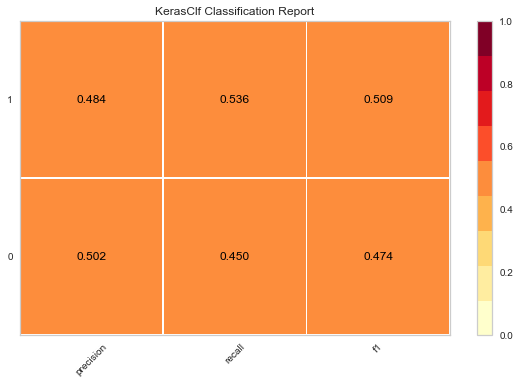

In [17]:
class KerasClf(BaseEstimator, ClassifierMixin, KerasClassifier):

    def __init__(self, build_fn, **kwargs):
        super(KerasClassifier, self).__init__(build_fn,  **kwargs)


def keras_model():
    #optimizer = tf.train.RMSPropOptimizer(0.001)
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer='sgd')

    return model
'''
def keras_model():
    model = Sequential()
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return model
'''
# Sklearn has a pipeline Class that directs the flow of model creation; 
# The pipeline corrals the features into the Random Forest classifer.
# Within the pipeline is a sklearn Class called FeatureUnion.
# Feature Union allows for the joining of multiple features into a single vector
# Within the feature union is a transformer list containing classes that performed the functions described above
# The final pipeline item is the declaration of a classifier that the combined feature vector will be inserted into

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
                      
            ('pipe', Pipeline([
                ('inner', FeatureUnion(
                    transformer_list=[
                        ('pos', POS()),

                        ('read', Readable()),

                        ('words', Words()),

                        ('blob', Pipeline([
                            ('all', Blob()),
                            ('minmax', MinMaxScaler()),
                        ])),
                ])),
                ('select', SelectFromModel(ExtraTreesClassifier()))
   
            ])),
                      
            ('title', Pipeline([
                ('tfidf', TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', ngram_range=(1,3), sublinear_tf=True,
                                          strip_accents='unicode', stop_words='english')),
                ('svd', TruncatedSVD(n_components=120)),
                ('normalize', MinMaxScaler(copy=False)),
                ('selector', SelectPercentile(f_classif, percentile=10))
            ])),

            
            ])),
    ('clf', KerasClf(build_fn=keras_model)),
        ])

# Train model
pipeline.fit(train_X, train_y)

# Predict Test Set
y_pred = pipeline.predict(test_X)

# Save our model
#joblib.dump(pipeline, 'datascience_keras.xz', compress=('xz', 9))

# Test it out
print(pipeline.predict(
    pd.Series(['Data Lakes and Pipelines','hackhub','Looking for MOOCs with actual projects to add to Github/Resume','A tutorial on my machine-learning workflow for predicting whether or not this post will be popular']
    )))


from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassBalance
visualizer = ClassificationReport(pipeline)
visualizer.fit(train_X, train_y)
visualizer.score(test_X,test_y)
visualizer.poof()

In [9]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('pipe', Pipeline(memory=None,
     steps=[('inner', FeatureUnion(n_jobs=None,
       transformer_list=[('pos', POS()), ('read', Readable()), ('words', Words()), ('blob', Pipeline(memory=None,
     steps=[('all', Blob()), ('minmax',...   transformer_weights=None)), ('clf', KerasClf(build_fn=<function keras_model at 0x7fc7578a9f28>))])>

### Model Evaluation - Preliminary Evaluation

In [24]:
# Measure prediction Accuracy and F1 Score
accuracy = accuracy_score(y_pred=y_pred, y_true=test_y)
print('Accuracy: {:03.1f}%'.format(accuracy * 100))

print('F1 Score: {:.3f}'.format(f1_score(test_y, y_pred)))

Accuracy: 50.9%
F1 Score: 0.032


In [ ]:
# Cross Validate prediction Score
print('CV Scores: ', cross_val_score(pipeline, train_X, train_y, cv=5))

### Model Evaluation - Visual Evaluation
In the Graphs below, False or Failure equates to less than 7.5 votes while True or Success equates to greater than 7.5 votes

/data/anaconda3/envs/calzone/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
6929/6929 [==============================] - 1s 93us/step - loss: 2.2461 - acc: 0.4969


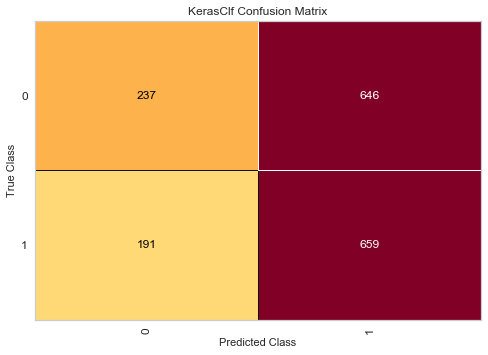

In [11]:
cm = ConfusionMatrix(pipeline)
cm.fit(train_X, train_y)
cm.score(test_X, test_y)
cm.poof()

/data/anaconda3/envs/calzone/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Epoch 1/1
6929/6929 [==============================] - 1s 98us/step - loss: 2.8233 - acc: 0.4985


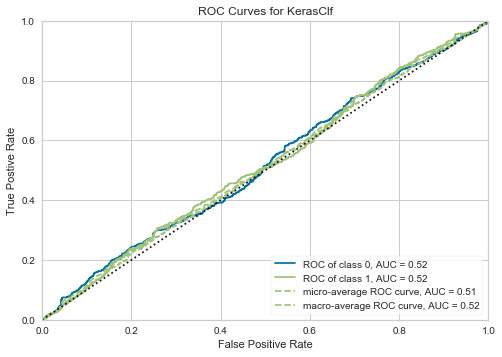

In [12]:
visualizer = ROCAUC(pipeline)
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
g=visualizer.poof()

|Classification Report          |Confusion Matrix               |
|:-----------------------------:|:-----------------------------:|
| <img src="images/clsreport1.png"> | <img src="images/confusion.png"> |

| Class Balance                 | ROC Curve                     |
|:-----------------------------:|:-----------------------------:|
| <img src="images/classbalance.png"> | <img src="images/rocauc.png"> |

## Conclusion:

My goal was to go through and document the entire process of building a classifier.  I learned a lot.  Now, I know that the title isn't sufficient enough to predict whether or not a post will be successful.  Getting to this conclusion after so many hours of work was heartbreaking but at the same time very fulfilling.  I hope you can take my failure and use it to build successful models.  Also, I hope you return for my follow-up blog post on how to predict the number of votes a title will receive.  Until next time, Adios :)

### P.S.  I am looking to switch careers from computational biology to data science.  Message me if you have any positions available.